# Transfer learning

### Using VGG16 pre-trained on ImageNet to classify on Clatech101

In [10]:
# Image processing from local files
from keras.preprocessing.image import ImageDataGenerator
image_size = 224


# Define directory roots
train_root = './101_ObjectCategories_test/101_ObjectCategories/train'
val_root = './101_ObjectCategories_test/101_ObjectCategories/val'
test_root = './101_ObjectCategories_test/101_ObjectCategories/test'

# Generate training set
train_datagen = ImageDataGenerator(rescale=1./255.)

train_dataset = train_datagen.flow_from_directory(
    train_root,
    target_size=(image_size, image_size),
    batch_size=32
)
                                

# Generate validation set   
val_datagen = ImageDataGenerator(rescale=1./255.)

val_dataset = val_datagen.flow_from_directory(
    val_root,
    target_size=(image_size, image_size),
    batch_size=32
)

# Generate test set
test_datagen = ImageDataGenerator(rescale=1./255.)

test_dataset = test_datagen.flow_from_directory(
    test_root,
    target_size=(image_size, image_size),
    batch_size=32
)

total_length = len(train_dataset.filenames) + len(val_dataset.filenames) + len(test_dataset.filenames)
print("Train, in percentage (%) : ", len(train_dataset.filenames)/total_length * 100)
print("Val, in percentage (%) : ", len(val_dataset.filenames)/total_length * 100)
print("Test, in percentage (%) : ", len(test_dataset.filenames)/total_length * 100)

Found 6782 images belonging to 102 classes.
Found 1464 images belonging to 102 classes.
Found 898 images belonging to 102 classes.
Train, in percentage (%) :  74.16885389326335
Val, in percentage (%) :  16.010498687664043
Test, in percentage (%) :  9.820647419072616


In [2]:
# Include all packages
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import Model
from tensorflow.keras import optimizers


In [3]:


base_model = VGG16(weights='imagenet',
                  include_top=True,
                  )

base_model.summary()


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________

In [4]:
# Modify VGG16 model to fit Caltech101.

input_layer = base_model.input

new_classification_layer = Dense(102, activation='softmax')

output_layer = new_classification_layer(base_model.layers[-2].output)


modified_VGG16 = Model(input_layer, output_layer)

modified_VGG16.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [5]:
# Make output layer trainabel. All other layers remains with same weights as for the pretrained VGG16 model.

for i, layer in enumerate(modified_VGG16.layers[:-1]):
    layer.trainable = False
    
for i, layer in enumerate(modified_VGG16.layers[-1:]):
    layer.trainable = True
    
modified_VGG16.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [6]:
modified_VGG16.compile(loss='categorical_crossentropy',
                      optimizer=optimizers.RMSprop(lr=1e-4),
                      metrics=['accuracy'])

history = modified_VGG16.fit(train_dataset,
                  validation_data=val_dataset,
                  epochs=20)

Epoch 1/20
212/212 [==============================] - 506s 2s/step - loss: 3.7245 - acc: 0.2237 - val_loss: 3.2206 - val_acc: 0.2746
Epoch 2/20
212/212 [==============================] - 494s 2s/step - loss: 2.8653 - acc: 0.3735 - val_loss: 2.6045 - val_acc: 0.4126
Epoch 3/20
212/212 [==============================] - 492s 2s/step - loss: 2.3550 - acc: 0.4822 - val_loss: 2.2279 - val_acc: 0.5280
Epoch 4/20
212/212 [==============================] - 494s 2s/step - loss: 2.0221 - acc: 0.5600 - val_loss: 1.9706 - val_acc: 0.5526
Epoch 5/20
212/212 [==============================] - 497s 2s/step - loss: 1.7937 - acc: 0.6109 - val_loss: 1.7791 - val_acc: 0.6072
Epoch 6/20
212/212 [==============================] - 498s 2s/step - loss: 1.6206 - acc: 0.6466 - val_loss: 1.6470 - val_acc: 0.6236
Epoch 7/20
212/212 [==============================] - 496s 2s/step - loss: 1.4890 - acc: 0.6676 - val_loss: 1.5468 - val_acc: 0.6318
Epoch 8/20
212/212 [==============================] - 497s 2s/step - 

In [7]:
modified_VGG16.save("VGG16.h5")

In [8]:
import numpy as np
data_history_training = history.history

np.save('VGG16_history.npy', data_history_training)

In [3]:
# Run model on test set from saved model

from tensorflow import keras

reconstructed_model_VGG16 = keras.models.load_model("VGG16.h5")
reconstructed_model_VGG16.evaluate(test_dataset)

29/29 [==============================] - 71s 2s/step - loss: 1.0628 - acc: 0.7639


[1.0628241300582886, 0.76391983]

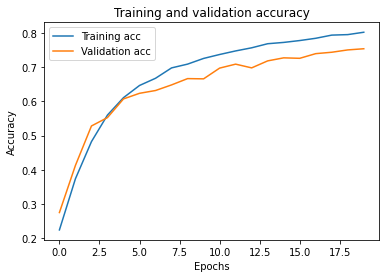

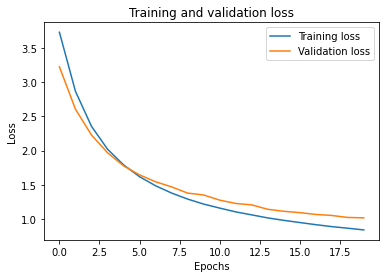

In [2]:
import numpy as np
reconstructed_history_VGG16 = np.load('VGG16_history.npy',allow_pickle='TRUE').item()

import matplotlib.pyplot as plt

acc = reconstructed_history_VGG16['acc']
val_acc = reconstructed_history_VGG16['val_acc']
loss = reconstructed_history_VGG16['loss']
val_loss = reconstructed_history_VGG16['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.figure()

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()
